# Introduction

In NLU challange , we'll analyze reddit_csv posts from Subreddit **Vaccine** to perform the following: 
- Sentiment analysis of user's posts and comments
- Topic modeling to extract hidden topics from the posts
From the results, we'll identify potential measures that might be helpful to debunk the common myths. Let's start by loading the required libraries and exploring the dataset.

In [136]:
#requirements
!pip install -U -q spacy
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.2.0/en_core_web_sm-3.2.0-py3-none-any.whl (13.9 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy
import re, string
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob # sentiment analysis
from sklearn.decomposition import NMF # topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer # document-term matrix creation

%matplotlib inline

In [138]:
# Set some default options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('darkgrid')
plt.rc('figure', facecolor='#00000000', figsize=(10,8))
plt.rc('font', size=12)

# Explore the Dataset
First, load the dataset into Pandas dataframe.

In [139]:
posts = pd.read_csv('reddit_vm.csv')
posts.head()

title  score      id  \
0  Health Canada approves AstraZeneca COVID-19 va...      7  lt74vw   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  lsh0ij   
2  Coronavirus variants could fuel Canada's third...      6  lohlle   
3  Canadian government to extend COVID-19 emergen...      1  lnptv8   
4  Canada: Pfizer is 'extremely committed' to mee...      6  lkslm6   

                                                 url  comms_num       created  \
0  https://www.canadaforums.ca/2021/02/health-can...          0  1.614400e+09   
1  https://www.canadaforums.ca/2021/02/covid-19-i...          1  1.614316e+09   
2  https://www.canadaforums.ca/2021/02/coronaviru...          0  1.613887e+09   
3  https://www.canadaforums.ca/2021/02/canadian-g...          0  1.613796e+09   
4  https://www.canadaforums.ca/2021/02/canada-pfi...          0  1.613468e+09   

  body            timestamp  
0  NaN  2021-02-27 06:33:45  
1  NaN  2021-02-26 07:11:07  
2  NaN  2021-02-21 07:50:08  
3  NaN  2021-02-20 06:35:13  
4  NaN  2021-02-16 11:36:28

In [140]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1602 non-null   object 
 1   score      1602 non-null   int64  
 2   id         1602 non-null   object 
 3   url        469 non-null    object 
 4   comms_num  1602 non-null   int64  
 5   created    1602 non-null   float64
 6   body       1226 non-null   object 
 7   timestamp  1602 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 100.2+ KB


# We can see that there are 1,602 entries and 8 columns. Let's first understand what each column entails.

title - title of post
score - score of post based on impact, number of comments
id - unique id for posts/comments
url - url of post thread
commns_num - number of comments to this post
created - date of creation
body - text of the post or comment
timestamp - timestamp of creation
We do not need id and url for this analysis. Also, created (UNIX timestamp) and timestamp contains the same information, so we'll remove created.

In [141]:
posts.drop(columns=['id', 'url', 'created'], inplace=True)
posts.head()

title  score  comms_num body  \
0  Health Canada approves AstraZeneca COVID-19 va...      7          0  NaN   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2          1  NaN   
2  Coronavirus variants could fuel Canada's third...      6          0  NaN   
3  Canadian government to extend COVID-19 emergen...      1          0  NaN   
4  Canada: Pfizer is 'extremely committed' to mee...      6          0  NaN   

             timestamp  
0  2021-02-27 06:33:45  
1  2021-02-26 07:11:07  
2  2021-02-21 07:50:08  
3  2021-02-20 06:35:13  
4  2021-02-16 11:36:28

There are some missing values under body, which is expected as some users might only share the post with title and url (which we already removed). Let's convert timestamp from object to datetime for subsequent analysis and plotting.

In [142]:
posts['timestamp'] =  pd.to_datetime(posts['timestamp'], format='%Y-%m-%d %H:%M:%S')
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      1602 non-null   object        
 1   score      1602 non-null   int64         
 2   comms_num  1602 non-null   int64         
 3   body       1226 non-null   object        
 4   timestamp  1602 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 62.7+ KB


# Explore Creation Date and Impact of Posts
add Codeadd Markdown
Let's see the breakdown of posts and comments in the dataset. There are 1,133 comments (~70%) out of 1,602 rows. The remaining 30% (n=469) are individual posts.

In [143]:
sum(posts['title'] == 'Comment')

1133

In [144]:
posts.sort_values(by=['score'], ascending=False).head(10)

title  score  comms_num  \
512           I would rage if this was handed to me...   1187        595   
510                                       From /r/Rage     45         13   
212                                   Vaccines exposed     38          4   
291  Do not give a platform for anti-vaxxers to pro...     32          5   
465                     Meet my friend's anti-vax wife     32          1   
276                   Vaccines have a huge side effect     30         13   
301                           Oh no! I got vaccinated!     28          6   
238                                         How ironic     28          3   
246                                   Vaccinate folks.     27          7   
586                              Why Trust Scientists?     26          1   

                                                  body           timestamp  
512                                                NaN 2014-04-02 05:32:42  
510                                                NaN 2014-04-02 23:01:49  
212                                                NaN 2020-12-18 05:11:12  
291  I am of the mind to report social media groups... 2019-02-12 01:04:08  
465                                                NaN 2014-04-29 22:47:41  
276  Vaccines have a huge side effect, vaccines are... 2019-06-08 11:16:35  
301  \n\n\nAnd I'm completely fine, do some researc... 2018-11-21 20:35:02  
238                                                NaN 2020-03-06 11:19:39  
246                                                NaN 2020-01-09 03:25:37  
586                                                NaN 2014-01-17 10:16:45

We can see the most impactful post has much more comments (n=595) than the other posts. We will analyze the sentiment of the comments later on. Looking at the post title, more of the top 10 posts do not seem to advocate vaccination.

Let's see the distribution of these posts and comments over the years.

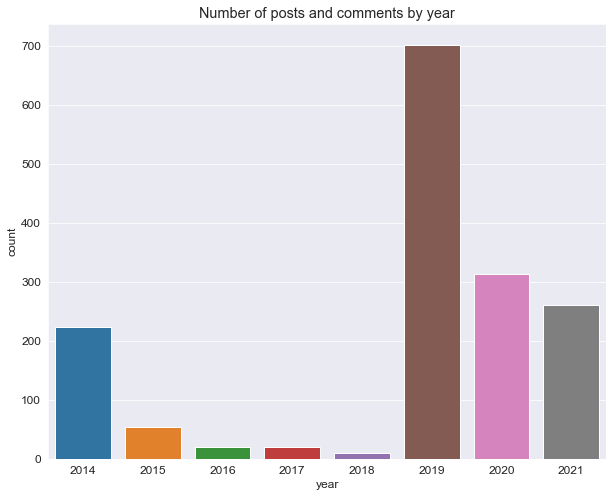

In [145]:
# Extract year and month of the data
posts['year'] = pd.DatetimeIndex(posts['timestamp']).year
posts['month'] = pd.DatetimeIndex(posts['timestamp']).month

# Create a count plot
sns.countplot(x='year', data=posts)
plt.title('Number of posts and comments by year')
plt.show()

From the plot, we know that Reddit community was created in 2014. Ever since, the number of posts and comments was downtrending until a surge in 2019. Let's see if the surge of vaccine discussions was related to COVID-19, which was first known in December 2019.

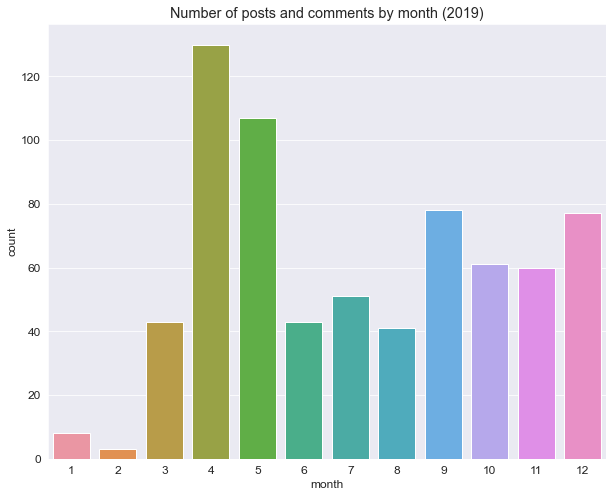

In [146]:
sns.countplot(x='month', data=posts.loc[posts['year'] == 2019])
plt.title('Number of posts and comments by month (2019)')
plt.show()

A lot of vaccine discussions already took place before the first known case of COVID-19 in December 2019.

We've completed the data exploration. Next, let's analyze sentiments and extract hidden topics (based on title) from the data. We'll start by preprocessing the texts.

# Text Preprocessing
It is important to make the text machine friendly before analysis. Hence, we'll apply the following steps to preprocess the text: convert words into lowercase, remove website link, remove special characters (e.g., number, emoji), remove punctuation, remove newline character, remove extra spaces and remove stopwords.

We'll be using spaCy, which is an open-source software library for advanced natural language processing (NLP), written in the programming languages Python and Cython.

In [147]:
def preprocess(sentence):
    """
    Convert text to lowercase
    Remove website link, special characters, newline character and extra spaces
    """
    sentence = str(sentence)
    sentence = sentence.lower()
    rem_spe_chr = re.sub(r"[-()\"#/@;:<>\[\]{}`+=~|.!?,]", "", sentence)
    rem_url = re.sub(r'http\S+', '', rem_spe_chr)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_num = re.sub(r'[0-9]+', '', rem_nl)
    rem_space = re.sub(r'\s\s+', ' ', rem_num)
    return rem_space

# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Add stopwords
STOP_WORDS.update(['vaccine', 'vaccination', 'vaccinate', 'vaccinated', 'use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'find', 'read', 'point'])

def lemmatize(sentence):
    # Create Doc object and disable components we don't need (for efficiency)
    doc = nlp(sentence, disable=['ner', 'parser'])

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    alp_lemmas = [lemma for lemma in lemmas 
                  if lemma.isalpha() and lemma not in STOP_WORDS] 

    return ' '.join(alp_lemmas)

In [148]:
# Create another dataframe that contains the cleaned text
posts_cleaned = posts.copy()

# Preprocess and lemmatize the title (non-comment) and body
posts_cleaned.loc[posts_cleaned['title'] != 'Comment', 'title'] = posts_cleaned.loc[posts_cleaned['title'] != 'Comment', 'title'].apply(preprocess).apply(lemmatize)
posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body'] = posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body'].apply(preprocess).apply(lemmatize)
posts_cleaned.tail()

title  score  comms_num  \
1597  Comment      2          0   
1598  Comment      1          0   
1599  Comment      0          0   
1600  Comment      1          0   
1601  Comment      1          0   

                                                   body           timestamp  \
1597  lol comprehension comprehensive look post thin... 2019-04-25 23:11:10   
1598  trouble thing trouble thing try I clever quip ... 2019-04-25 23:02:04   
1599                                   music play dance 2019-04-25 22:53:50   
1600  long ethyl mercury metabolize happen brain lon... 2019-04-25 22:35:39   
1601  sound I scrape barrel bounce erratically fully... 2019-04-25 22:21:34   

      year  month  
1597  2019      4  
1598  2019      4  
1599  2019      4  
1600  2019      4  
1601  2019      4

# Sentiment Analysis
Let's perform sentiment analysis to understand the opinion of the authors about the vaccines. We'll first generate a wordcloud to see what were the common words mentioned by the author.

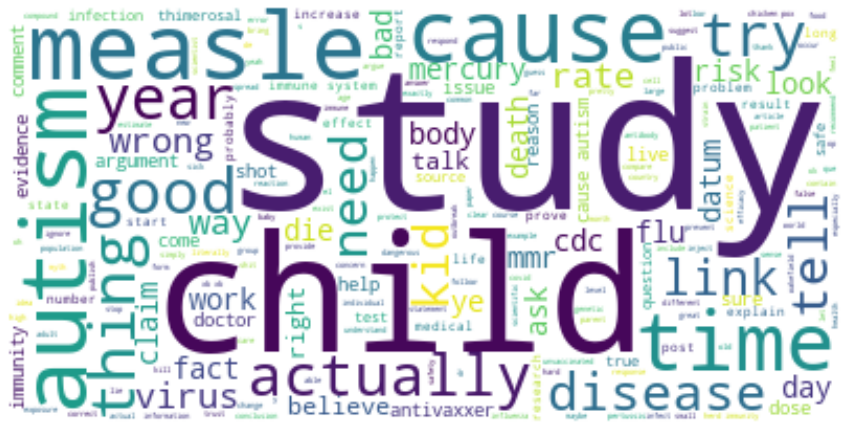

In [149]:
# Import the word cloud function  
from wordcloud import WordCloud

# Iterate through body column to join the text in all rows
body_words = ''
for sentence in posts_cleaned.loc[~posts_cleaned['body'].isnull(), 'body']:
    body_words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=STOP_WORDS, max_words=200).generate(body_words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

From the wordcloud, we can see some common words like study, child, autism, measle, good and time. As we cannot infer the semantic meaning of a sentence using wordcloud, let's use TextBlob, a simple Python Library which allows us to perform sentiment analysis using lexicon-based approaches (i.e., define sentiment by semantic orientation and intensity of each word in a sentence).

TextBlob returns two properties of a given input sentence:

Polarity: lies within [-1, 1]. -1 defines a negative sentiment, 1 defines a positive sentiment and 0 defines a neutral sentiment. TextBlob has semantic labels to recognize emoticons, exclamation marks, emojis, etc. Hence, we'll use the original body column (before removal of special characters) for analysis to preserve its semantics.
Subjectivity: lies within [0, 1]. The higher the score (toward 1), the more personal opinion (instead of factual information) the sentence contains.

In [150]:
# Create columns for sentiment and subjectivity
posts['sentiment'] = np.NaN
posts['subjectivity'] = np.NaN

def basic_preprocess(sentence):
    """Perform basic preprocessing of text without removing special characters"""
    sentence = str(sentence)
    rem_url = re.sub(r'http\S+', '', sentence)
    rem_url = re.sub(r'www\S+', '', rem_url)
    rem_nl = re.sub(r'\n', ' ', rem_url)
    rem_space = re.sub(r'\s\s+', ' ', rem_nl)
    return rem_space

def get_sentiment(sentence):
    """Extract sentiment from text based on polarity value"""
    if sentence != '':
      score = TextBlob(sentence).sentiment.polarity
      if score < 0:
          return "Negative"
      elif score == 0:
          return "Neutral"
      else:
          return "Positive"

def get_subjectivity(sentence):
    """Calculate subjectivity of text"""
    return TextBlob(sentence).sentiment.subjectivity

In [151]:
# Apply basic preprocessing for body text
posts.loc[~posts['body'].isnull(), 'body'] = posts.loc[~posts['body'].isnull(), 'body'].apply(basic_preprocess)

# Populate the sentiment and subjectivity
posts.loc[~posts['body'].isnull(), 'sentiment'] = posts.loc[~posts['body'].isnull(), 'body'].apply(get_sentiment)
posts.loc[~posts['body'].isnull(), 'subjectivity'] = posts.loc[~posts['body'].isnull(), 'body'].apply(get_subjectivity)

Let's take a look at the breakdown of sentiments of the body text.

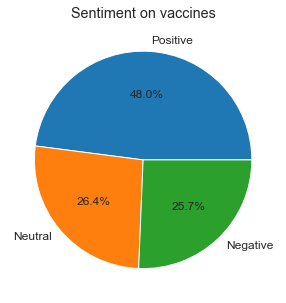

In [152]:
# Create a pie chart
fig, ax = plt.subplots(figsize=(8,5))
ax.pie(posts['sentiment'].value_counts(normalize=True), labels = ['Positive', 'Neutral', 'Negative'], autopct='%1.1f%%')
ax.set_title('Sentiment on vaccines')
plt.show();

We can see that ~48% of the text sentiments are classified as positive, ~26% as neutral and ~26% as negative. Let's randomly select a few positive and negative sentiments to see how TextBlob has performed in classifying the sentiment.

In [153]:
list(posts.loc[posts['sentiment'] == 'Positive', 'body'].sample(5))

['Yes. If they are enhanced by**. Chinese get Shots. Their immune system is burdened as well as purged of natural disease detourants.',
 "Good luck getting this through their thick skulls, they ask for peer reviewed papers, and even then will ignore it. Trust me, i've tried to tell them this.",
 'So are you saying that the manipulation of science is not my original argument?',
 'Antivaxers still want their kids to live healthily, but they are misinformed about vaccines, it\'s not a bout not wanting the child to live. >Well,survival of the god damn fittest, when my kid is eating the food your kid could\'ve eaten if they were in a family that relies on facts and evidence instead of phony "studies", I\'ll be laughing my ass off. Food? what are you on about here?',
 ">I'm not attacking you as a person, I am however heavily disagreeing with your willingness to debate topics whose nuances and basics you know little about. > >Seriously. How many times have I told you this? Do legitimate resea

In [154]:
list(posts.loc[posts['sentiment'] == 'Neutral', 'body'].sample(5))

['Yes talk to me',
 "I'm compiling evidence against a website, to educate some antivax friends on vaccines.",
 'You think?',
 "Dude this is a Wendy's",
 "He litterally comes out in support of vaccines here. And even if he didn't one person's opinion doesn't nullify 99.99% of scientists and basic immunology."]

In [155]:
list(posts.loc[posts['sentiment'] == 'Negative', 'body'].sample(5))

[">READ THE PAPER You ask us to read the paper but don't provide a link. This is worthless.",
 "Don't use skeptical raptor, he has made a lot of mistakes",
 '>You clearly misunderstood what I said Maybe I did, could you clarify? >if you\'re going to shut down like this All i\'m trying to "shut down" is a ridiculous diversion into false speculation about my motives for saying the title is wrong, the reason I think it is wrong is because if vaccines caused something it could affect 1 in 1 million kids or 1 in 5, or anywhere in between',
 'What do you mean by "your OP". I am fairly new to reddit.',
 'The chemical pathway forEthel-mercury shows no damage to the brain. Ethel mercury has the same likelihood of causing Brain damage (regardless of age) as sodium chloride causing a cardiac event, as in the case of sodium Pentothal. Iâ€™ll']

It seems like the classification is reasonable, although not highly accurate. This is expected as lexicon-based sentiment analysis might not handle different words (e.g., slang, informal words used on social media) in different contexts well because the sentiment is predicted based on pre-defined rules which might not be adapted to the specific domain.

If we have labeled historical datasets, we can train a machine learning model (e.g., Naive Bayes classifier, logistic regression) to predict the sentiments. Generally, this approach would yield a higher accuracy as the model can learn "patterns" from the labeled dataset.

Before we move on to topic modelling, let's take a quick look at the summary statistics and distribution of subjectivity of the texts.

In [156]:
posts['subjectivity'].describe()

count    1226.000000
mean        0.401241
std         0.283161
min         0.000000
25%         0.168750
50%         0.439583
75%         0.583929
max         1.000000
Name: subjectivity, dtype: float64

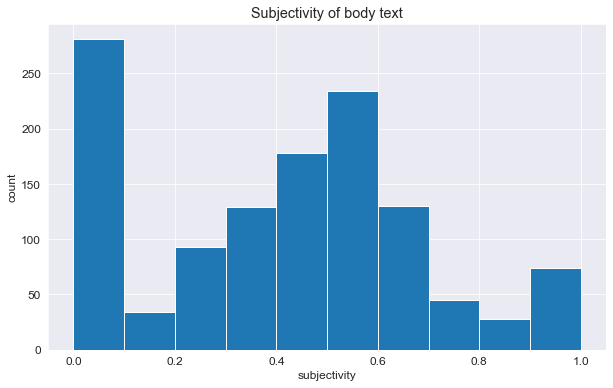

In [157]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(posts['subjectivity'])
plt.title('Subjectivity of body text')
plt.xlabel('subjectivity')
plt.ylabel('count')
plt.show();

The mean subjectivity is ~0.4. If using 0.5 as a guide, a higher proportion of posts and comments are less subjective.

# Topic Modeling

It is interesting to see if we can extract prevailing topics from the posts. Here, we would use a technique called non-negative matrix factorization (NMF), which decomposes the **document-term matrix** into two smaller matrices - **document-topic matrix** and **topic-term matrix**. A document is composed of a mix of topics, and a topic is composed of a mix of terms. 


![image](https://miro.medium.com/max/500/1*ru1Ek9T3FjkehDkD8FZoHQ.jpeg)

[Image source](https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8)

We will exclude pure comments from the topic modeling as the comments are the responses to the `title`. Before fitting the model, let's look at the word count distribution of each title.

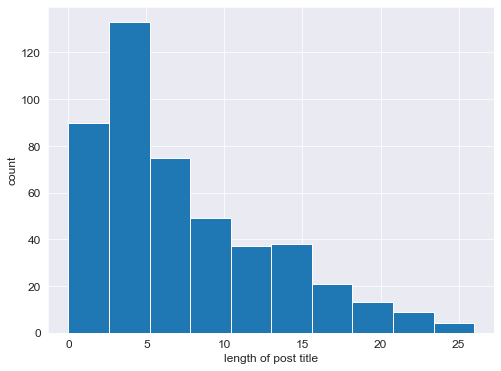

In [158]:
def count_words(string):
    """Count the number of words in each string"""
    words = string.split()
    return len(words)

# Extract posts with title (exclude comments)
posts_with_title = posts_cleaned[posts_cleaned['title'] != 'Comment'].copy()

# Calculate the sentence length
posts_with_title['title_word_count'] = posts_with_title['title'].apply(count_words)

# Plot sentence length distribution
plt.figure(figsize=(8,6))
plt.hist(posts_with_title['title_word_count'])
plt.xlabel('length of post title')
plt.ylabel('count')
plt.show();

add Codeadd Markdown
In general, >50% of the post titles are less than 10 words.

Now, we need to turn the post titles into numbers as the model does not understand texts. We'll use scikit-learn TfidfVectorizer to create term frequency-inverse document frequency (tf-idf) matrix. In essence, this formula will weigh each word based on its appearance in a document (i.e., a single post title here) and its appearance across the entire corpus (i.e., all the post titles here). If a word appears in many documents, its weightage (tf-idf) will be reduced as it doesn't mean much to the document in particular.

Read here for more detailed explanation of tf-idf.

In [159]:
# Create tf-idf matrix - ignore terms that have a document frequency strictly higher than 95% and less than 2
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(posts_with_title['title'].values.astype(str))

print(tfidf.shape)

(469, 509)


We now have a document-term matrix with shape of (469, 509), i.e., 469 titles (documents) and 507 vocabularies. We can use this as the input to scikit-learn NMF model. Let's set the number of topics as 5.

*It is important to pick the right number of topics as too few topics produce results that are too broad, while too many topics product results that are highly similar. However, there is currently no means to score NMF model in scikit-learn. For those who are interested, you can try Gensim's LDA topic modeling, for which a metric called "coherence score" can be used to compare models with different number of topics. In this analysis, we will stick to NMF model.

In [160]:
# Fit NMF model to post titles
nmf = NMF(n_components=5, random_state=1).fit(tfidf)
nmf_output = nmf.fit_transform(tfidf)
print(nmf_output.shape)

(469, 5)


C:\Users\21653\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\21653\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


The NMF output is a non-negative matrix that represents the document-topic matrix with a shape of (469, 5). Let's create a function to display the topics and the top 10 words in each topic.

In [161]:
def get_topic_keywords(vectorizer, model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        # Find the indices of top n words with the highest weightage 
        top_keyword_locs = (-topic_weights).argsort()[:n_words]

        # Extract the keywords based on indices
        topic_keywords.append(keywords.take(top_keyword_locs))
    
    return topic_keywords

# Get the top 10 words for each topic
topic_keywords = get_topic_keywords(vectorizer=tfidf_vectorizer, model=nmf, n_words=10)   

# Display the topic and its top 10 keywords
for i in range(len(topic_keywords)):
    print("Topic {}: {}".format(i, ' '.join(topic_keywords[i])))

Topic 0: autism cause mmr link court proof owner prove cdc bad
Topic 1: covid canada penicillin magnetic la pfizer actually coronavirus prevent available
Topic 2: measle myth outbreak body mump chance polio baby die daughter
Topic 3: child unvaccinated parent reason polio year mmr choose immunity right
Topic 4: help need antivax debunk antivaxxer anti new discuss podcast vax


Looking at the keywords from each topic, we can postulate what each topic might be.

Topic 0: debate about link of vaccine (mmr) with autism
Topic 1: approval/use of COVID-19 vaccine in the world
Topic 2: safety of vaccine
Topic 3: vaccination uptake in children and its link with parent
Topic 4: anti-vaccination and vaccine myths
Let's assign the post titles to the topic that constitutes the highest weightage among all the 5 topics.

In [162]:
# Get the index of the highest topic weightage
posts_with_title['topic'] = nmf_output.argmax(axis=1)
posts_with_title.head()

title  score  comms_num body  \
0            health canada approve astrazeneca covid      7          0  NaN   
1   covid canada passport near certainty bioethicist      2          1  NaN   
2               coronavirus variant fuel canada wave      6          0  NaN   
3  canadian government extend covid emergency ben...      1          0  NaN   
4  canada pfizer extremely committed meet deliver...      6          0  NaN   

            timestamp  year  month  title_word_count  topic  
0 2021-02-27 06:33:45  2021      2                 5      1  
1 2021-02-26 07:11:07  2021      2                 6      1  
2 2021-02-21 07:50:08  2021      2                 5      1  
3 2021-02-20 06:35:13  2021      2                 6      1  
4 2021-02-16 11:36:28  2021      2                 7      1

We can look at the percentage of each topic and find out the most representative post title for each topic.


In [163]:
posts_with_title['topic'].value_counts(normalize=True)

4    0.336887
3    0.270789
0    0.208955
2    0.098081
1    0.085288
Name: topic, dtype: float64

In [164]:
# Extract the document that has the highest weightage under each topic
posts_with_title.iloc[nmf_output.argmax(axis=0)]

title  score  comms_num  \
245                               cause autism      0          9   
135  cast covid volunteer freezer truck driver      6          0   
218                            measle overview      3          0   
298                                      child     21         24   
267                         I need help debunk      5          1   

                                                  body           timestamp  \
245  wonderful daughter hailey autism autistic doct... 2020-01-11 12:51:59   
135                                                NaN 2021-03-02 02:58:59   
218                                                NaN 2020-11-25 09:34:22   
298  mom extremely antivax swear let I long live I ... 2019-01-03 06:41:44   
267                                                NaN 2019-08-28 07:40:54   

     year  month  title_word_count  topic  
245  2020      1                 2      0  
135  2021      3                 6      1  
218  2020     11                 2      2  
298  2019      1                 1      3  
267  2019      8                 4      4

Most posts (34%) were related to topic 4 (anti-vaccination and vaccine myths), while topic 1 (COVID-19 vaccine approval and use) has the lowest number of posts (8%).

The most representative post title each topic seems to tally with our postulation (except for topic 2). Let's look at more posts under topic 2.

In [165]:
list(posts_with_title.loc[posts_with_title['topic'] == 2, 'title'].sample(10))

['check blog expose myth',
 'dr dre slightly credible',
 'cancer virus',
 'pretty terribly write blog',
 'hydration cold rag need measle work wonder apparently hype death measle',
 'myth legend surround tetanus shot',
 'worth risk thimerosil I mercury body son body I chance measle',
 'death myth',
 'video dr maurice hilleman develop measle mump hep hep b chickenpox meninigit pneumonia merck admit cancer virus',
 'wait']


These posts seem to be related to safety profile of vaccine (topic 2). Our NMF topic model has a reasonable performance.

From the topic modeling outputs, we can see potential areas (e.g., vaccine use and autism, thimerosal/mercury in vaccine) that might contribute to vaccine hesitancy and skepticism. More targeted education on vaccination can be considered.

# Conclusion
We have come to the end of this analysis. From sentiment analysis and topic modeling, we observed the following:

Around half of the sentiments were positive, with another half split between neutral and negative
The discussions on Reddit were centered around autism, COVID-19 vaccine, vaccine safety, vaccination in children and anti-vaccination.
It is important not to forget the limitations of data, methodology and findings. Some of the limitations we have are listed:

Social media data is subjected to high bias - social media users are not representative of the underlying population.
Results from Reddit data are not generalizable to all countries (a large proportion of Reddit users are located in the United States).
We only have data from one Reddit community. There are other vaccine communities discussing different aspects of vaccines.
We do not have labeled historical dataset to train machine learning model for sentiment prediction.
NMF topic modeling in scikit-learn doesn't have score to compare models with different number of chosen topics. Other models such as Gensim's LDA can be considered.